<a href="https://colab.research.google.com/github/hbedros/data608-story2/blob/main/Haig_Bedros_DATA_608_Story_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Story - 2 : Can the FED Control Inflation and Maintain Full Employment



In [20]:
import requests
import pandas as pd

# BLS API for CPI and Employment Rates
def fetch_bls_data(series_id, start_year, end_year, bls_api_key):
    bls_url = f"https://api.bls.gov/publicAPI/v2/timeseries/data/{series_id}?registrationkey={bls_api_key}&startyear={start_year}&endyear={end_year}"
    response = requests.get(bls_url)
    data = response.json()
    return data['Results']['series'][0]['data']

    # FRED API for Federal Rates
    fred_url = f"https://api.stlouisfed.org/fred/series/observations?series_id=FEDFUNDS&api_key={fred_api_key}&file_type=json"
    response = requests.get(fred_url)
    data = response.json()

# API keys. Didn't store them locally. But keeping them here for documentation.
bls_api_key = "121e9e38b2824da7ac495f5c958d526e"
fred_api_key = "6595c43e6f76defe130cc6ef2d3208f7"

# Fetch CPI data (CUUR0000SA0) from BLS
cpi_data_1 = fetch_bls_data('CUUR0000SA0', 1999, 2012, bls_api_key)
cpi_data_2 = fetch_bls_data('CUUR0000SA0', 2013, 2024, bls_api_key)
combined_cpi_data = cpi_data_1 + cpi_data_2

# Fetch unemployment data (LNS14000000) from BLS
unemployment_data_1 = fetch_bls_data('LNS14000000', 1999, 2012, bls_api_key)
unemployment_data_2 = fetch_bls_data('LNS14000000', 2013, 2024, bls_api_key)
combined_unemployment_data = unemployment_data_1 + unemployment_data_2

# Extract observations (Federal Funds Rate data)
observations = data['observations']

# Convert FRED data to DataFrame
df_fed = pd.DataFrame(observations)

# Extract Year and Month from the 'date' column in FRED data
df_fed['Year'] = pd.to_datetime(df_fed['date']).dt.year
df_fed['Month'] = pd.to_datetime(df_fed['date']).dt.strftime('%B')

# Convert 'value' to numeric (float) and rename to 'Federal Funds Rate'
df_fed['Federal Funds Rate'] = pd.to_numeric(df_fed['value'], errors='coerce')

# Select only the relevant columns
df_fed_final = df_fed[['Year', 'Month', 'Federal Funds Rate']]

# Create a list of dictionaries with the CPI data
parsed_cpi_data = [{'Year': int(item['year']), 'Month': item['periodName'], 'CPI Value': float(item['value'])} for item in combined_cpi_data]

# Create a list of dictionaries with the unemployment data
parsed_unemployment_data = [{'Year': int(item['year']), 'Month': item['periodName'], 'Unemployment Rate': float(item['value'])} for item in combined_unemployment_data]

# Convert the lists of dictionaries to DataFrames
df_cpi = pd.DataFrame(parsed_cpi_data)
df_unemployment = pd.DataFrame(parsed_unemployment_data)

# Convert 'CPI Value' and 'Unemployment Rate' to numeric and 'Year' to int
df_cpi['Year'] = df_cpi['Year'].astype(int)
df_cpi['CPI Value'] = pd.to_numeric(df_cpi['CPI Value'], errors='coerce')

df_unemployment['Year'] = df_unemployment['Year'].astype(int)
df_unemployment['Unemployment Rate'] = pd.to_numeric(df_unemployment['Unemployment Rate'], errors='coerce')

# Merge CPI and Unemployment DataFrames on 'Year' and 'Month'
df_combined = pd.merge(df_cpi, df_unemployment, on=['Year', 'Month'], how='inner')

# Merge the combined data with the Federal Funds Rate data
df_combined = pd.merge(df_combined, df_fed_final, on=['Year', 'Month'], how='inner')

print(df_combined)

     Year      Month  CPI Value  Unemployment Rate  Federal Funds Rate
0    2012   December    229.601                7.9                0.16
1    2012   November    230.221                7.7                0.16
2    2012    October    231.317                7.8                0.16
3    2012  September    231.407                7.8                0.14
4    2012     August    230.379                8.1                0.13
5    2012       July    229.104                8.2                0.16
6    2012       June    229.478                8.2                0.16
7    2012        May    229.815                8.2                0.16
8    2012      April    230.085                8.2                0.14
9    2012      March    229.392                8.2                0.13
10   2012   February    227.663                8.3                0.10
11   2012    January    226.665                8.3                0.08
12   2011   December    225.672                8.5                0.07
13   2

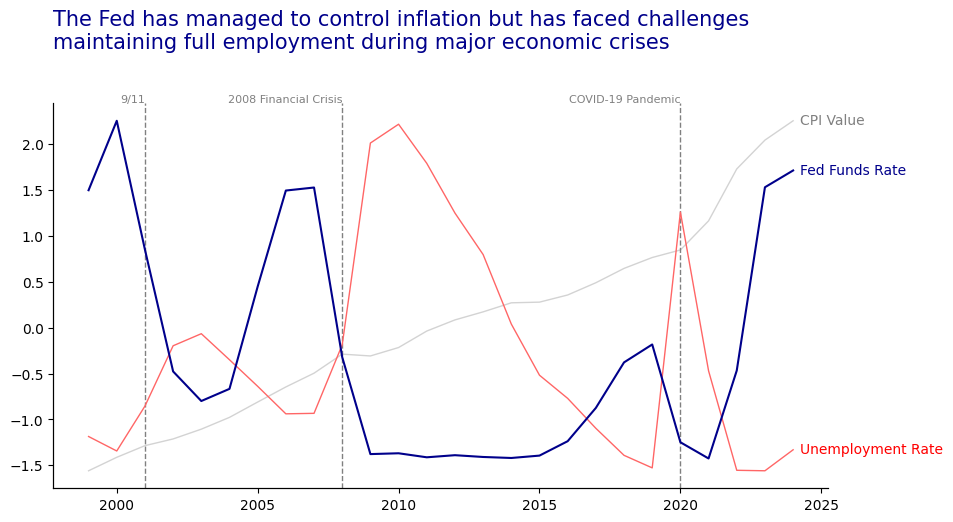

In [19]:
import matplotlib.pyplot as plt
import numpy as np

# Standardize all three variables using Z-Score standardization
df_combined['Standardized Federal Funds Rate'] = (df_combined['Federal Funds Rate'] - df_combined['Federal Funds Rate'].mean()) / df_combined['Federal Funds Rate'].std()
df_combined['Standardized Unemployment Rate'] = (df_combined['Unemployment Rate'] - df_combined['Unemployment Rate'].mean()) / df_combined['Unemployment Rate'].std()
df_combined['Standardized CPI Value'] = (df_combined['CPI Value'] - df_combined['CPI Value'].mean()) / df_combined['CPI Value'].std()

# Calculate the average Standardized CPI Value, Standardized Unemployment Rate, and Standardized Federal Funds Rate per year
df_grouped = df_combined.groupby('Year').agg({
    'Standardized CPI Value': 'mean',
    'Standardized Unemployment Rate': 'mean',
    'Standardized Federal Funds Rate': 'mean'
}).reset_index()


# Create a figure and axis
fig, ax1 = plt.subplots(figsize=(10, 5))

# Plot Standardized CPI Value on the left y-axis
ax1.plot(df_grouped['Year'], df_grouped['Standardized CPI Value'], color='#D3D3D3', label='Standardized CPI Value', linewidth=1)

# Remove the top and right borders (spines)
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)

# Create a twin y-axis to plot the Standardized Unemployment Rate and Standardized Federal Funds Rate
ax2 = ax1.twinx()
ax2.plot(df_grouped['Year'], df_grouped['Standardized Unemployment Rate'], color='#FF6666', linestyle='-', label='Standardized Unemployment Rate', linewidth=1)

# Plot Standardized Federal Funds Rate on the same y-axis as Unemployment Rate
ax2.plot(df_grouped['Year'], df_grouped['Standardized Federal Funds Rate'], color='darkblue', linestyle='-', label='Standardized Federal Funds Rate', linewidth=1.5)

# Remove right-side ticks and labels for the unemployment rate
ax2.tick_params(axis='y', which='both', right=False)
ax2.set_yticklabels([])  # Remove the tick labels on the right side

# Annotate Standardized CPI Value with the most recent value
ax1.annotate(f'CPI Value', xy=(df_grouped['Year'].iloc[-1], df_grouped['Standardized CPI Value'].iloc[-1]),
             xytext=(5, 0), textcoords='offset points', color='gray', fontsize=10, verticalalignment='center')

# Annotate Standardized Unemployment Rate with the most recent value
ax2.annotate(f'Unemployment Rate', xy=(df_grouped['Year'].iloc[-1], df_grouped['Standardized Unemployment Rate'].iloc[-1]),
             xytext=(5, 0), textcoords='offset points', color='r', fontsize=10, verticalalignment='center')

# Annotate Standardized Federal Funds Rate with the most recent standardized value
ax2.annotate(f'Fed Funds Rate', xy=(df_grouped['Year'].iloc[-1], df_grouped['Standardized Federal Funds Rate'].iloc[-1]),
             xytext=(5, 0), textcoords='offset points', color='darkblue', fontsize=10, verticalalignment='center')

# Add vertical lines for major US events
ax1.axvline(x=2001, color='gray', linestyle='--', lw=1)  # 9/11
ax1.axvline(x=2008, color='gray', linestyle='--', lw=1)  # 2008 Financial Crisis
ax1.axvline(x=2020, color='gray', linestyle='--', lw=1)  # COVID-19 Pandemic

# Simplified annotations at the bottom (above the x-axis)
ax1.text(2001, ax1.get_ylim()[0] + 4.3, '9/11', color='gray', ha='right', va='top', fontsize=8)
ax1.text(2008, ax1.get_ylim()[0] + 4.3, '2008 Financial Crisis', color='gray', ha='right', va='top', fontsize=8)
ax1.text(2020, ax1.get_ylim()[0] + 4.3, 'COVID-19 Pandemic', color='gray', ha='right', va='top', fontsize=8)

# Remove the top and right spines for the twin axis
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)

plt.title("The Fed has managed to control inflation but has faced challenges \n"
          "maintaining full employment during major economic crises\n\n", fontsize=15, loc='left', color='darkblue')

plt.show()
